In [1]:
from src.statespace import RWModel, CVModel, CAModel, StateSpace
from src.trajectory import Trajectory
from src.kalmanfilter import KalmanFilter
from src.auxil import rmse, plot_estimates, plot_rmse, plot_traj
from src.kfnet import KFNet

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# sns.set()
sns.set_style("white")
# plt.style.use('seaborn-poster')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
RANDOM_SEED = None
ndat = 200
q = 9.5e-5          # Process noise intensity
r = 1.3             # Observation noise std
c_rwm = 10          # RWM process noise multiplicative constant
expf = 0.95         # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)
init_state = np.zeros(6)

In [4]:
# Trajectory simulator initialization
traj = Trajectory(
            CAModel(q, r),
            n_steps=ndat,
            n_obs=10,
            init_state=init_state,
            random_seed=RANDOM_SEED
)

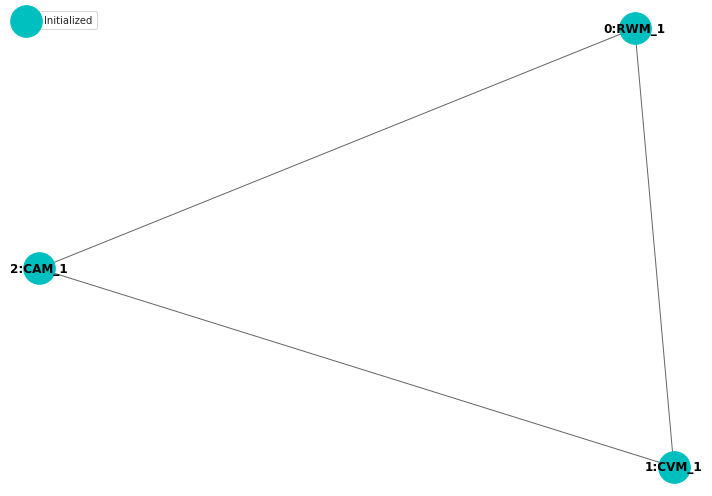

In [5]:
KFN_SEED = 5

kfs = [
    KalmanFilter(RWModel(c_rwm*q, r), lambda_expf=expf),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CAModel(q, r)),
]
np.random.seed(KFN_SEED)
np.random.shuffle(kfs)
# lbls = ["RWM", "CVM", "CAM"]
# lbls = {n:lbl for n, lbl  in enumerate(lbls)}

w_adapt = np.ones((3, 3))
w_adapt[:,2] = 0.5
w_combine = np.ones((3, 3))
w_combine[:,2] = 0.5

kfn = KFNet(3, 4, init=kfs, w_adapt=w_adapt, w_combine=w_combine, random_seed=KFN_SEED)
kfn.generate_txt_labels()
kfn.draw_network()

In [6]:
for yt in traj.observations:
    kfn.time_step(
        yt,
        predict=True,
        update=True,
        adapt=True,
        combine=True,
        reset_strategy="ci",
        reset_thresh=reset_thresh
    )

In [7]:
RWM = kfn[0]
CVM = kfn[1]
CAM = kfn[2]

In [8]:
kfcam = KalmanFilter(CAModel(q, r))

for yt in traj.observations[:, 2]:
    kfcam.predict()
    kfcam.update(yt, log=True)

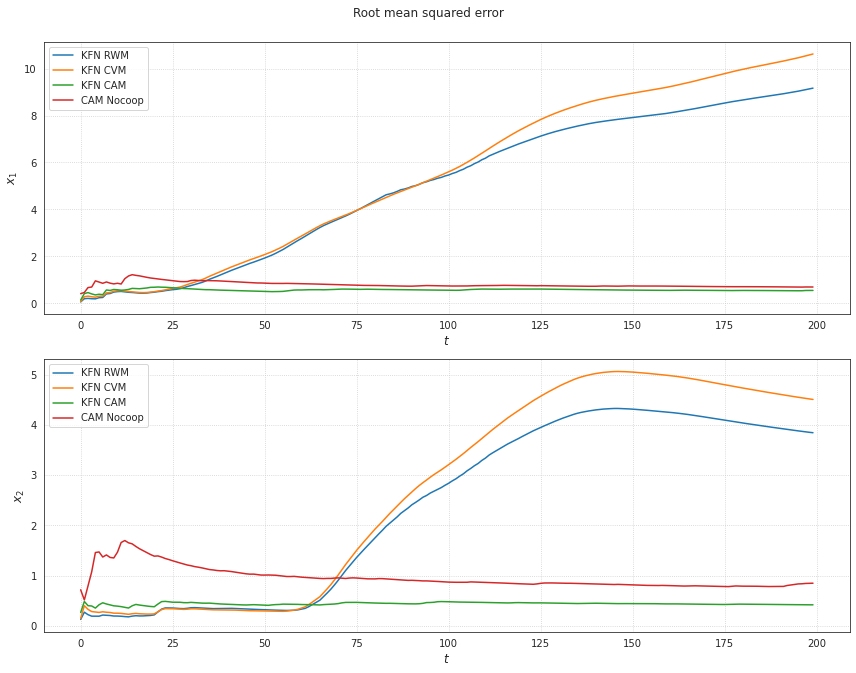

In [9]:
plot_rmse(traj, RWM, CVM, CAM, kfcam, nvars=2, var_labels=["$x_1$", "$x_2$"], kf_labels=["KFN RWM", "KFN CVM", "KFN CAM", "CAM Nocoop"])

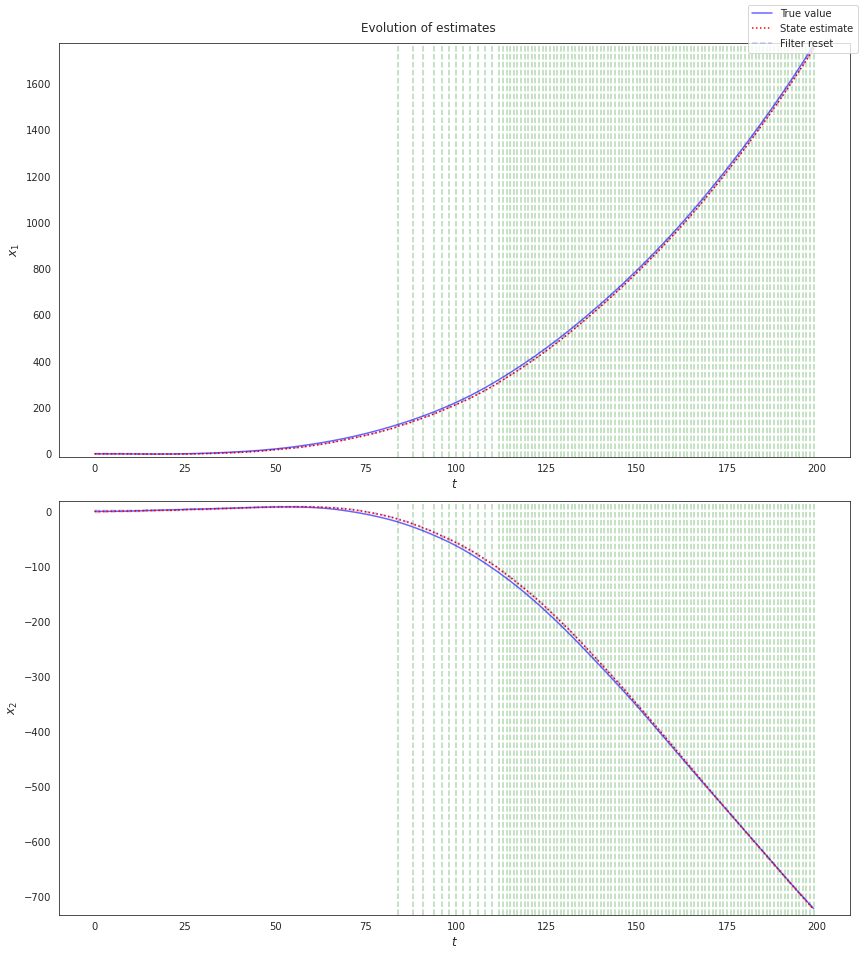

In [10]:
plot_estimates(RWM, traj, nvars=2, plt_std=True, labels=["$x_1$", "$x_2$"])

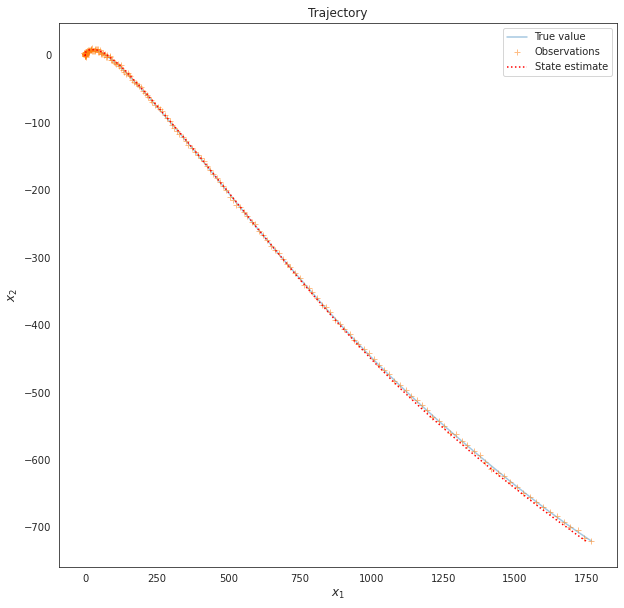

In [11]:
plot_traj(traj, obs=6, kf=RWM)

In [13]:
kfn.print_node_attr(attr="nbh_est", node="all")

(0, [(array([1766.94701434, -719.51795247]), array([[1000.,    0.],
       [   0., 1000.]])), (array([1750.2194867, -721.9829338]), array([[0.08991156, 0.        ],
       [0.        , 0.08991156]])), (array([1766.68656055, -720.8756127 ]), array([[0.23069562, 0.        ],
       [0.        , 0.23069562]]))])
(1, [(array([1750.2194867 , -721.9829338 ,   22.16976966,   -7.483429  ]), array([[0.08991156, 0.        , 0.0070752 , 0.        ],
       [0.        , 0.08991156, 0.        , 0.0070752 ],
       [0.0070752 , 0.        , 0.00115976, 0.        ],
       [0.        , 0.0070752 , 0.        , 0.00115976]]))])
(2, [(array([ 1.76668656e+03, -7.20875613e+02,  2.48139274e+01, -7.25198519e+00,
        2.32498532e-01,  2.15260698e-02]), array([[0.23069562, 0.        , 0.05308226, 0.        , 0.00610702,
        0.        ],
       [0.        , 0.23069562, 0.        , 0.05308226, 0.        ,
        0.00610702],
       [0.05308226, 0.        , 0.01990915, 0.        , 0.00318372,
        0.  

In [12]:
kfn.print_node_attr(attr="w_combine", node="all")

(0, [1.0, 1.0, 0.5])
(1, [1.0])
(2, [0.5])
